In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150


In [43]:
df_olist_customers_dataset = pd.read_csv("data/olist_customers_dataset.csv")
df_olist_order_items_dataset = pd.read_csv("data/olist_order_items_dataset.csv")
df_olist_order_payments_dataset = pd.read_csv("data/olist_order_payments_dataset.csv")
df_olist_order_reviews_dataset = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_olist_orders_dataset = pd.read_csv("data/olist_orders_dataset.csv")
df_olist_products_dataset = pd.read_csv("data/olist_products_dataset.csv")
df_olist_sellers_dataset = pd.read_csv("data/olist_sellers_dataset.csv")
df_product_category_name_translation = pd.read_csv("data/product_category_name_translation.csv")

#df_olist_geolocation_dataset = pd.read_csv("data/olist_geolocation_dataset.csv")

In [44]:
from functions import *
df_olist_order_reviews_dataset['length_comment_title'] = df_olist_order_reviews_dataset["review_comment_title"].apply(lambda x:length_str(x))
df_olist_order_reviews_dataset['length_comment_message'] = df_olist_order_reviews_dataset["review_comment_message"].apply(lambda x:length_str(x))
df_olist_order_reviews_dataset.drop(["review_comment_title","review_comment_message"],axis=1,inplace=True)

In [45]:
df_olist_products_dataset["product_photos_qty"].fillna(0,inplace=True)
df_olist_products_dataset["product_photos_qty"] = df_olist_products_dataset["product_photos_qty"].astype('int8')
df_olist_products_dataset["product_category_name"].fillna("unknown",inplace=True)
df_olist_products_dataset["product_description_lenght"].fillna(0,inplace=True)
df_olist_products_dataset.drop("product_name_lenght",axis=1,inplace=True)

In [46]:
df_product = df_olist_products_dataset.merge(df_product_category_name_translation,how="outer",on="product_category_name")
df_product["product_category_name_english"].fillna("unknown",inplace=True)
df_product.drop("product_category_name",axis=1,inplace=True)

In [47]:
df_olist_order_items_dataset = df_olist_order_items_dataset.groupby(["order_id","product_id","seller_id"]).agg({"order_item_id":"count","price":"sum","freight_value":"sum"})
df_olist_order_items_dataset.columns=['nb_items', 'sum_price', 'sum_freight_value']
df_olist_order_items_dataset.reset_index(inplace=True)

In [48]:
df_merge = df_olist_orders_dataset.merge(df_olist_order_reviews_dataset,how="outer",on="order_id")

In [49]:
df_merge = df_merge.merge(df_olist_order_payments_dataset,how="outer",on="order_id")

In [50]:
df_merge = df_merge.merge(df_olist_order_items_dataset,how="outer",on="order_id")

In [51]:
df_merge = df_merge.merge(df_olist_customers_dataset,how="outer",on="customer_id")

In [52]:
df_merge = df_merge.merge(df_product,how="outer",on="product_id")

In [53]:
df_merge = df_merge.merge(df_olist_sellers_dataset,how="outer",on="seller_id")

<AxesSubplot: >

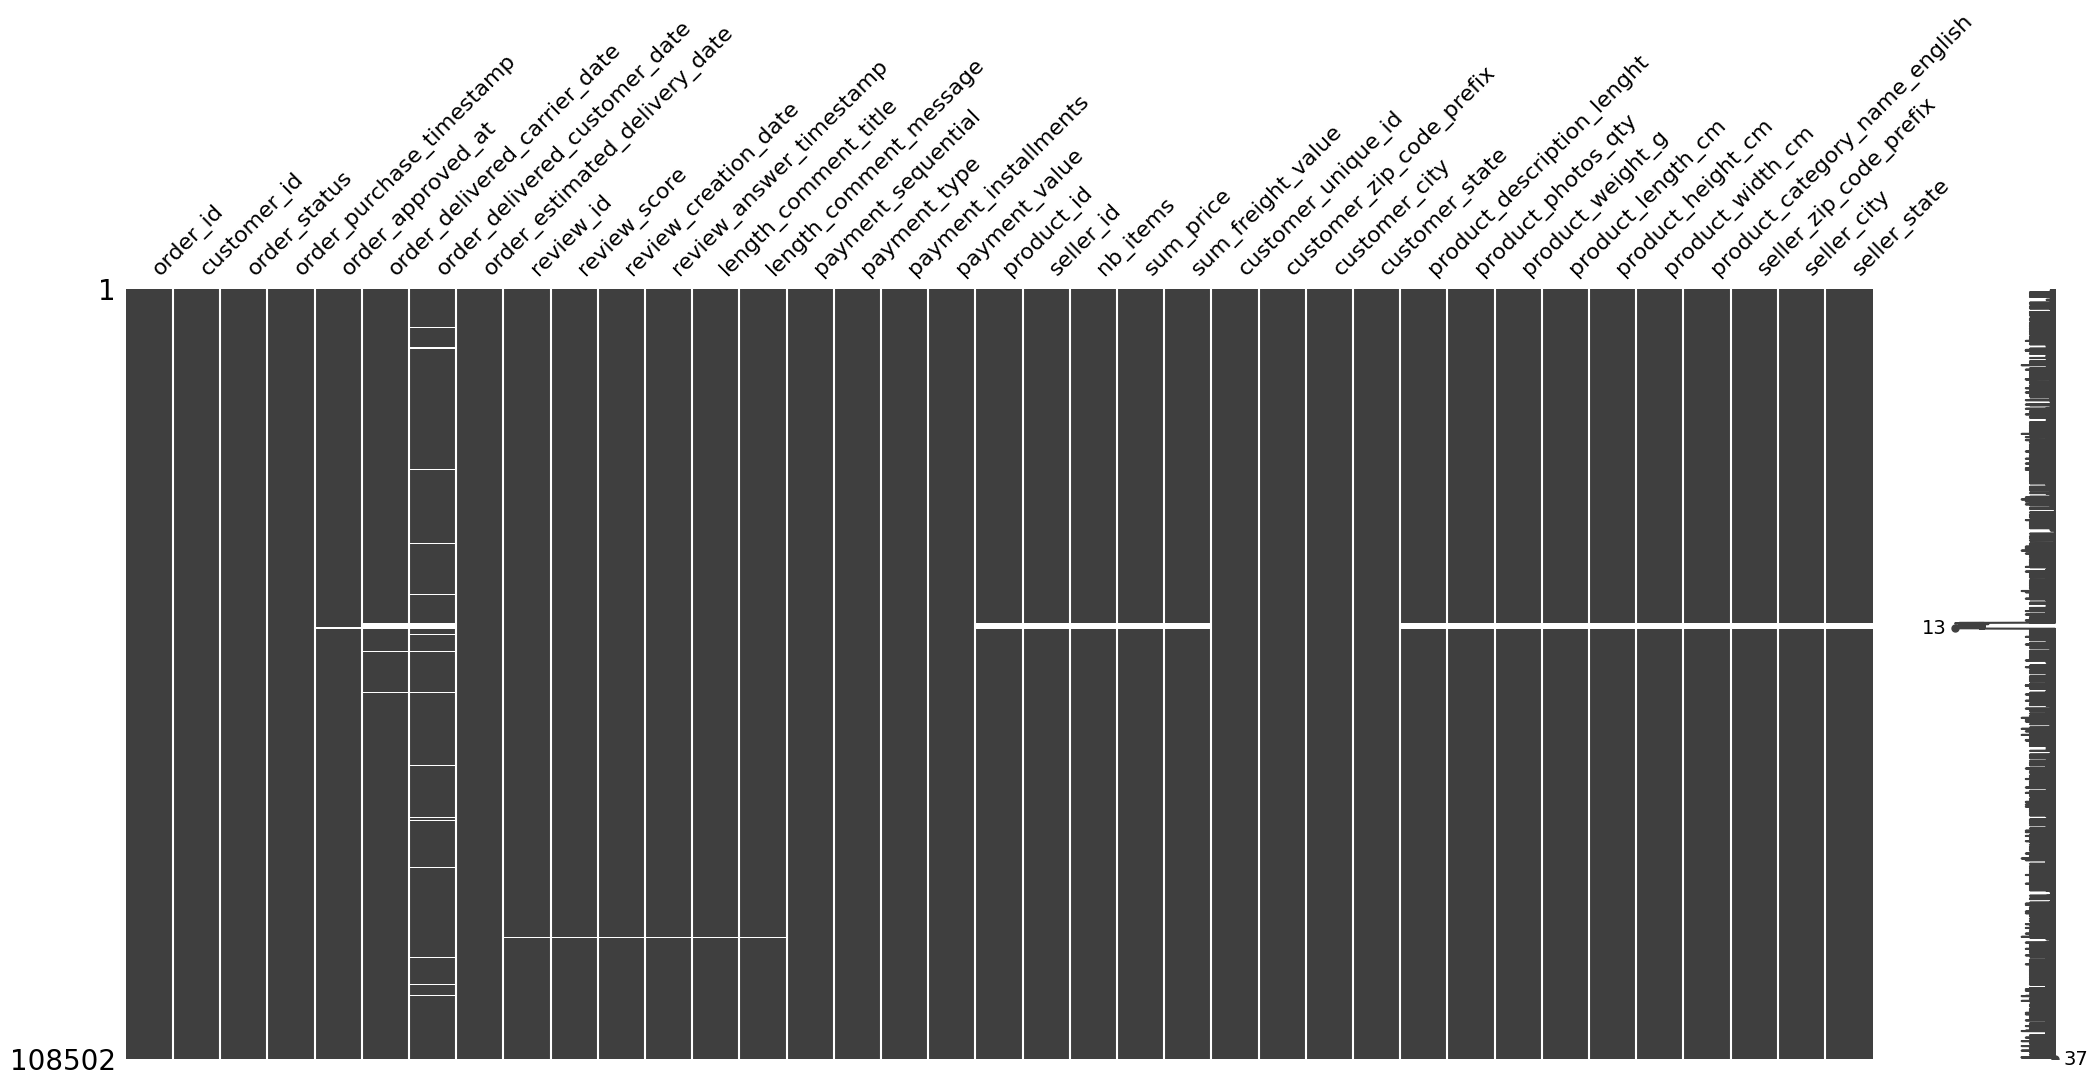

In [54]:
import missingno as msno

msno.matrix(df_merge)

In [55]:
df_merge["product_category_name_english"].unique()

array(['housewares', 'baby', 'cool_stuff', 'sports_leisure', 'toys',
       'furniture_decor', 'perfumery', 'health_beauty', 'music',
       'pet_shop', 'computers', 'construction_tools_construction',
       'signaling_and_security', 'auto', 'watches_gifts', 'audio',
       'electronics', 'computers_accessories', 'telephony',
       'consoles_games', 'stationery', 'party_supplies', 'unknown',
       'fashion_male_clothing', 'fashio_female_clothing', 'food',
       'costruction_tools_tools', 'fashion_bags_accessories',
       'garden_tools', 'office_furniture', 'furniture_living_room',
       'market_place', 'bed_bath_table', 'home_confort', 'art',
       'home_construction', 'air_conditioning',
       'agro_industry_and_commerce', 'fixed_telephony',
       'musical_instruments', 'luggage_accessories', 'fashion_sport',
       'fashion_shoes', 'home_appliances',
       'small_appliances_home_oven_and_coffee', 'small_appliances',
       'construction_tools_lights',
       'kitchen_dining_

In [56]:
df_merge[df_merge["order_id"]=="895ab968e7bb0d5659d16cd74cd1650c"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,length_comment_title,length_comment_message,payment_sequential,payment_type,payment_installments,payment_value,product_id,seller_id,nb_items,sum_price,sum_freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state
32210,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,eef5dbca8d37dfce6db7d7b16dd0525e,5.0,2017-08-15 00:00:00,2017-08-17 22:17:55,0.0,0.0,17.0,voucher,1.0,16.70,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2.0,25.98,46.42,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
32211,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,eef5dbca8d37dfce6db7d7b16dd0525e,5.0,2017-08-15 00:00:00,2017-08-17 22:17:55,0.0,0.0,1.0,voucher,1.0,2.61,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2.0,25.98,46.42,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
32212,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,eef5dbca8d37dfce6db7d7b16dd0525e,5.0,2017-08-15 00:00:00,2017-08-17 22:17:55,0.0,0.0,13.0,voucher,1.0,16.70,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2.0,25.98,46.42,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
32213,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,eef5dbca8d37dfce6db7d7b16dd0525e,5.0,2017-08-15 00:00:00,2017-08-17 22:17:55,0.0,0.0,16.0,voucher,1.0,16.70,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2.0,25.98,46.42,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
32214,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,eef5dbca8d37dfce6db7d7b16dd0525e,5.0,2017-08-15 00:00:00,2017-08-17 22:17:55,0.0,0.0,19.0,voucher,1.0,0.24,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2.0,25.98,46.42,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
32215,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,eef5dbca8d37dfce6db7d7b16dd0525e,5.0,2017-08-15 00:00:00,2017-08-17 22:17:55,0.0,0.0,4.0,voucher,1.0,2.61,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2.0,25.98,46.42,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
32216,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,eef5dbca8d37dfce6db7d7b16dd0525e,5.0,2017-08-15 00:00:00,2017-08-17 22:17:55,0.0,0.0,21.0,voucher,1.0,0.28,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2.0,25.98,46.42,9a736b248f67d166d2fbb006bcb87

In [ ]:
cat=['housewares', 'baby', 'cool_stuff', 'sports_leisure', 'toys',
       'furniture_decor', 'perfumery', 'health_beauty', 'music',
       'pet_shop', 'computers', 'construction_tools_construction',
       'signaling_and_security', 'auto', 'watches_gifts', 'audio',
       'electronics', 'computers_accessories', 'telephony',
       'consoles_games', 'stationery', 'party_supplies', 'unknown',
       'fashion_male_clothing', 'fashio_female_clothing', 'food',
       'costruction_tools_tools', 'fashion_bags_accessories',
       'garden_tools', 'office_furniture', 'furniture_living_room',
       'market_place', 'bed_bath_table', 'home_confort', 'art',
       'home_construction', 'air_conditioning',
       'agro_industry_and_commerce', 'fixed_telephony',
       'musical_instruments', 'luggage_accessories', 'fashion_sport',
       'fashion_shoes', 'home_appliances',
       'small_appliances_home_oven_and_coffee', 'small_appliances',
       'construction_tools_lights',
       'kitchen_dining_laundry_garden_furniture',
       'industry_commerce_and_business', 'drinks', 'food_drink',
       'books_general_interest', 'home_appliances_2',
       'construction_tools_safety', 'christmas_supplies',
       'furniture_mattress_and_upholstery', 'home_comfort_2',
       'costruction_tools_garden', 'fashion_underwear_beach',
       'arts_and_craftmanship', 'fashion_childrens_clothes',
       'books_technical', 'dvds_blu_ray', 'flowers', 'cds_dvds_musicals',
       'security_and_services', 'tablets_printing_image',
       'furniture_bedroom', 'cine_photo', 'diapers_and_hygiene',
       'books_imported', 'la_cuisine']

maison=['housewares','home_appliances', 'la_cuisine', 'home_confort','home_comfort_2','home_appliances_2', 'office_furniture','home_construction', 'air_conditioning']
outil = ['construction_tools_construction','construction_tools_lights','costruction_tools_tools','construction_tools_safety']
jardinnage=['flowers','costruction_tools_garden', 'garden_tools',]
mobilier_electromenager=['furniture_living_room','small_appliances_home_oven_and_coffee', 'small_appliances','furniture_mattress_and_upholstery', 'kitchen_dining_laundry_garden_furniture','furniture_bedroom','bed_bath_table','furniture_decor']
enfant=['diapers_and_hygiene','baby','toys']
fashion=['fashion_sport', 'fashion_childrens_clothes','fashion_underwear_beach','fashion_shoes','fashion_male_clothing', 'fashio_female_clothing','fashion_bags_accessories',]
sport=['sports_leisure']
auto=['auto','signaling_and_security']
service=['industry_commerce_and_business','agro_industry_and_commerce','security_and_services','market_place']
fete = ['party_supplies','christmas_supplies',]
papeterie=["stationery"]
beaute=['perfumery','health_beauty']
music=['music','musical_instruments','cds_dvds_musicals']
animaux=['pet_shop']
voyage=['luggage_accessories']
informatique=[ 'computers','watches_gifts','audio','fixed_telephony','tablets_printing_image','electronics', 'computers_accessories', 'telephony',]
loisir=['consoles_games','dvds_blu_ray']
alimentation=['food', 'drinks', 'food_drink',]
livre=['books_technical','books_general_interest','books_imported']
inconue=["unknown"]
autre=['cool_stuff']
art=['art','arts_and_craftmanship','cine_photo']

In [38]:
df_merge.drop(
    ['order_id', 
       'review_id', 'payment_sequential', 'product_id',
       'seller_id', 
       'customer_unique_id', 'customer_zip_code_prefix', 
       'seller_zip_code_prefix']
    ,axis=1,inplace=True
       )

<AxesSubplot: >

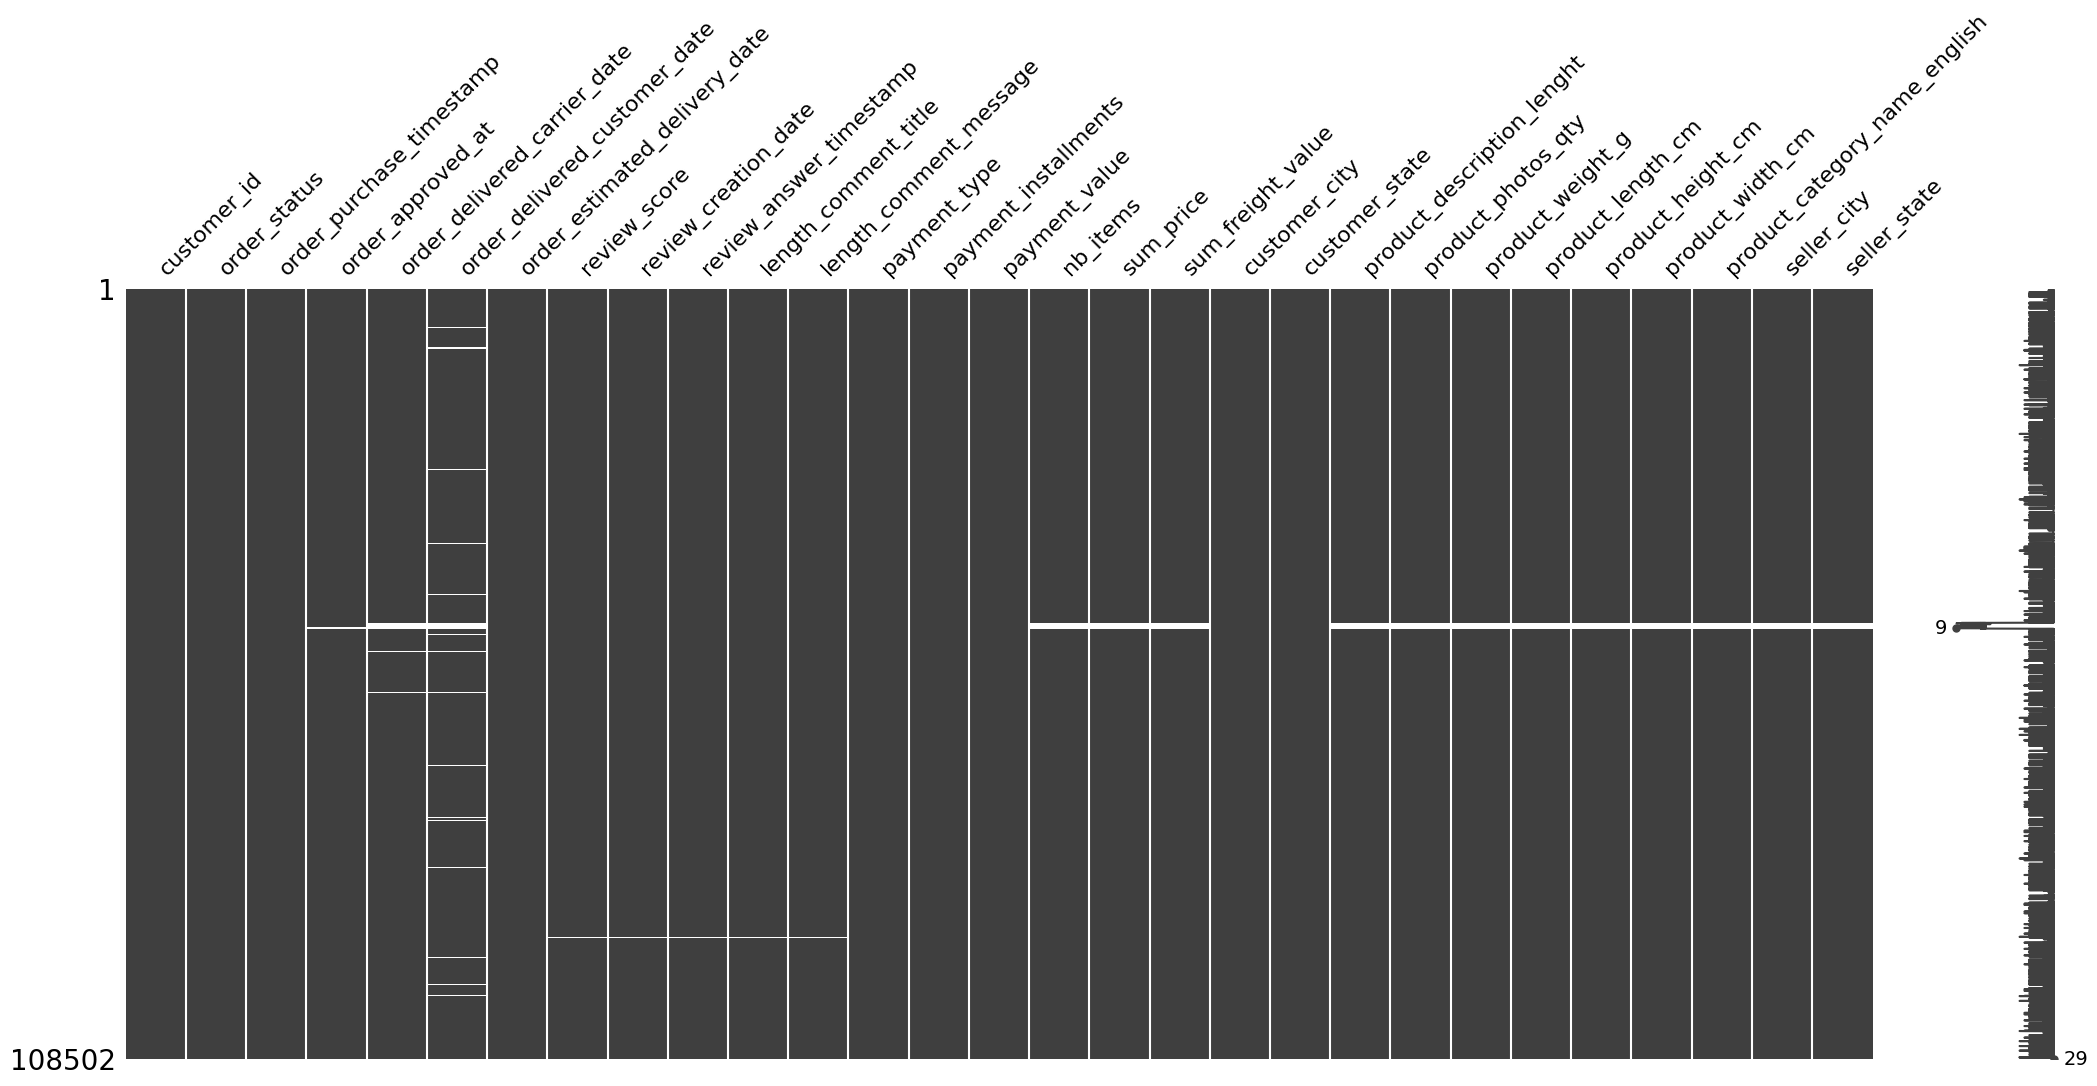

In [39]:
msno.matrix(df_merge)

In [40]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108502 entries, 0 to 108501
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    108502 non-null  object 
 1   order_status                   108502 non-null  object 
 2   order_purchase_timestamp       108502 non-null  object 
 3   order_approved_at              108326 non-null  object 
 4   order_delivered_carrier_date   106583 non-null  object 
 5   order_delivered_customer_date  105306 non-null  object 
 6   order_estimated_delivery_date  108502 non-null  object 
 7   review_score                   107652 non-null  float64
 8   review_creation_date           107652 non-null  object 
 9   review_answer_timestamp        107652 non-null  object 
 10  length_comment_title           107652 non-null  float64
 11  length_comment_message         107652 non-null  float64
 12  payment_type                  

In [ ]:
df_merge.info()

In [ ]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df_merge, title="Pandas Profiling Report")
# profile.to_file(output_file='rapport.html')

In [ ]:
# df_merge.to_csv("data/data_merge.csv",index=False)